<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-images" data-toc-modified-id="Import-images-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import images</a></span></li><li><span><a href="#Image-preprocessing" data-toc-modified-id="Image-preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Image preprocessing</a></span></li><li><span><a href="#Transfer-Learning" data-toc-modified-id="Transfer-Learning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Transfer Learning</a></span></li><li><span><a href="#Train/test-split" data-toc-modified-id="Train/test-split-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train/test split</a></span></li></ul></div>

In [1]:
import os
import sys

import numpy as np

import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

import urllib

import tarfile

In [2]:
GITHUB_PATH = ".."
DL_PATH = os.path.join(GITHUB_PATH, "deep-learning")
SCRAPING_PATH = os.path.join(DL_PATH, "scraping")
GG_PATH = os.path.join(SCRAPING_PATH, "google_images")
IMAGES_PATH = os.path.join(GG_PATH, "download")

In [ ]:
facePath = "computer-vision\\smile_detection\\haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(facePath)

In [3]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [4]:
width = 299
height = 299
channels = 3

## Import images

In [5]:
os.listdir(IMAGES_PATH)

['Griezmann', 'Lloris', 'Mbappé', 'Pogba']

In [6]:
def import_images(path=IMAGES_PATH):
    dict_path = dict()
    
    classes = os.listdir(path)
    for classe in classes:
        dict_path[classe] = []
        class_dir = os.path.join(path, classe)
        class_dir_ = os.path.abspath(class_dir)
        images = os.listdir(class_dir)
        for image in images:
            img_path = os.path.join(class_dir_, image)
            if img_path.endswith(".jpg"):
                dict_path[classe].append(img_path)
            
    return dict_path

In [7]:
img_dict = import_images()

Class: Griezmann


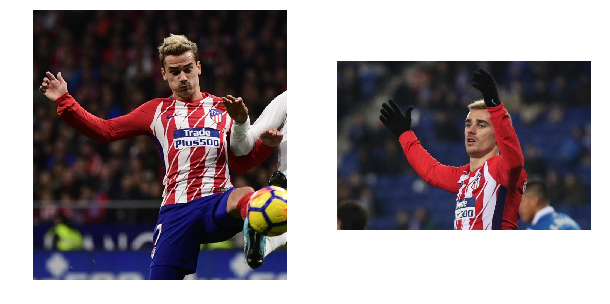

Class: Lloris


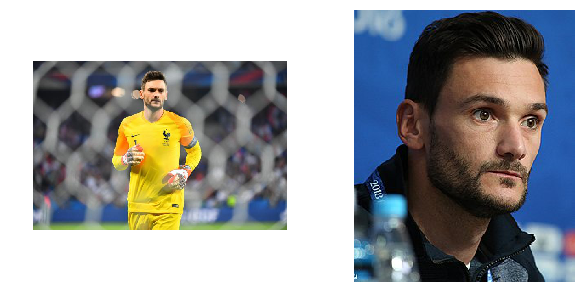

Class: Mbappé


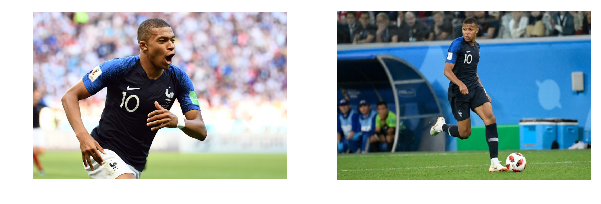

Class: Pogba


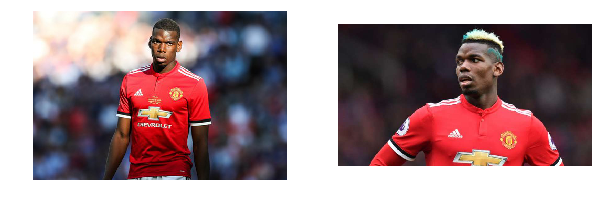

In [8]:
for classe in img_dict.keys():
    print("Class:", classe)
    plt.figure(figsize=(10,5))
    
    img_path_0 = img_dict[classe][0]
    img_path_1 = img_dict[classe][1]
    
    img0 = mpimg.imread(img_path_0)[:, :, :]
    img1 = mpimg.imread(img_path_1)[:, :, :]
    
    plt.subplot(121)
    plt.imshow(img0)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(img1)
    plt.axis("off")
    plt.show()

In [9]:
player_classes = img_dict.keys()

player_class_ids = {player_class: index for index, player_class in enumerate(player_classes)}

player_class_ids

{'Griezmann': 0, 'Lloris': 1, 'Mbappé': 2, 'Pogba': 3}

In [10]:
player_paths_and_classes = []

for player_class, paths in img_dict.items():
    for path in paths:
        player_paths_and_classes.append((path, player_class_ids[player_class]))
        
np.random.shuffle(player_paths_and_classes)

In [11]:
player_paths_and_classes[:3]

[('C:\\Users\\lgrosjean\\Documents\\GitHub\\deep-learning\\scraping\\google_images\\download\\Griezmann\\Griezmann117.jpg',
  0),
 ('C:\\Users\\lgrosjean\\Documents\\GitHub\\deep-learning\\scraping\\google_images\\download\\Mbappé\\Mbappé128.jpg',
  2),
 ('C:\\Users\\lgrosjean\\Documents\\GitHub\\deep-learning\\scraping\\google_images\\download\\Griezmann\\Griezmann32.jpg',
  0)]

##  Image preprocessing

In [12]:
img_path = img_dict["Mbappé"][0]
img = mpimg.imread(img_path)[:, :, :]

In [13]:
def  prepare_image_with_tensorflow(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    image_shape = tf.cast(tf.shape(image), tf.float32)
    height = image_shape[0]
    width = image_shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = tf.cond(crop_vertically,
                         lambda: width,
                         lambda: height * target_image_ratio)
    crop_height = tf.cond(crop_vertically,
                          lambda: width / target_image_ratio,
                          lambda: height)

    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = tf.random_uniform(shape=[], minval=1.0, maxval=1.0 + max_zoom)
    crop_width = tf.cast(crop_width / resize_factor, tf.int32)
    crop_height = tf.cast(crop_height / resize_factor, tf.int32)
    box_size = tf.stack([crop_height, crop_width, 3])   # 3 = number of channels

    # Let's crop the image using a random bounding box of the size we computed
    image = tf.random_crop(image, box_size)

    # Let's also flip the image horizontally with 50% probability:
    image = tf.image.random_flip_left_right(image)

    # The resize_bilinear function requires a 4D tensor (a batch of images)
    # so we need to expand the number of dimensions first:
    image_batch = tf.expand_dims(image, 0)

    # Finally, let's resize the image to the target dimensions. Note that this function
    # returns a float32 tensor.
    image_batch = tf.image.resize_bilinear(image_batch, [target_height, target_width])
    image = image_batch[0] / 255  # back to a single image, and scale the colors from 0.0 to 1.0
    return image

In [14]:
def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    
    #reset_graph()
    
    input_image = tf.placeholder(tf.uint8, shape=[None, None, 3])
    prepared_image_op = prepare_image_with_tensorflow(input_image)

    with tf.Session():
        prepared_image = prepared_image_op.eval(feed_dict={input_image: image})
    
    return prepared_image

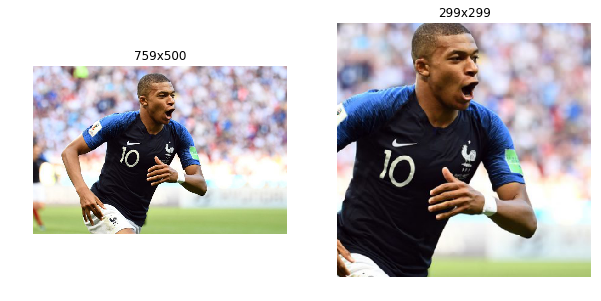

In [15]:
prepared_image = prepare_image(img)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img)
plt.title("{}x{}".format(img.shape[1], img.shape[0]))
plt.axis("off")
plt.subplot(122)
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

We need to focus on faces.

In [40]:
def crop_face(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor= 1.05,
        minNeighbors=8,
        minSize=(55, 55),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    
    cropped_faces = list()
    
    if len(faces) == 0:
        cropped_faces.append(img)
    
    else:
        for x,y,w,h in faces:
            cropped_faces.append(img[y:y+h, x:x+w].copy())
    
    #print("Faces found: {}".format(len(cropped_faces)))
    return cropped_faces

In [19]:
img_path = img_dict["Pogba"][8]
img = mpimg.imread(img_path)[:, :, :]

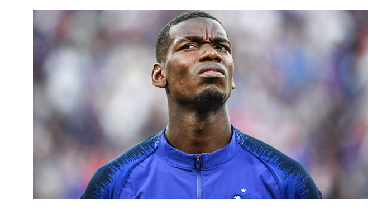

In [20]:
plt.imshow(img)
plt.axis("off")
plt.show()

In [21]:
cropped_imgs = crop_face(img)

Faces found: 1


In [22]:
cropped_img = cropped_imgs[0]

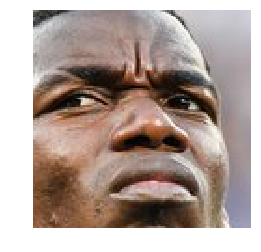

In [23]:
plt.imshow(cropped_img)
plt.axis("off")
plt.show()

In [24]:
prepared_img = prepare_image(cropped_img)

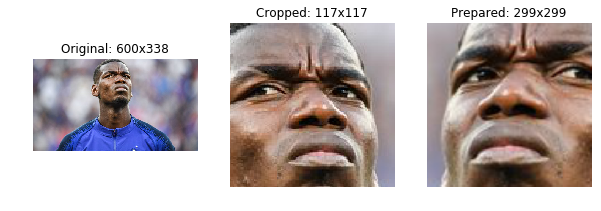

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(img)
plt.title("Original: {}x{}".format(img.shape[1], img.shape[0]))
plt.axis("off")
plt.subplot(132)
plt.imshow(cropped_img)
plt.title("Cropped: {}x{}".format(cropped_img.shape[1], cropped_img.shape[0]))
plt.axis("off")
plt.subplot(133)
plt.imshow(prepared_img)
plt.title("Prepared: {}x{}".format(prepared_img.shape[1], prepared_img.shape[0]))
plt.axis("off")
plt.show()

In [41]:
def prepare_image_face(img):
    cropped_faces = crop_face(img)
    cropped_img = cropped_imgs[0]
    prepared_img = prepare_image(cropped_img)
    return prepared_img

##  Transfer Learning

In [27]:
TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

In [28]:
def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

In [29]:
def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)  

In [30]:
fetch_pretrained_inception_v3()

We need to find where the new output layer should be attached (we will freeze all layers up to the bottleneck layer, ie the last layer before the output layer), and replace the output layer with the appropriate number of outputs for the new classification task (ie the dataset with Lloris, Griezmann, Pogba and Mbappé). The output layer must have 4 neurons and use the softmax activation function.

In [31]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

In [32]:
end_points["PreLogits"]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

We can drop the 2nd and 3rd dimensions using the `tf.Squeeze()` function.

In [33]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

Then, let's add the final fully connected layer on top of this layer

In [34]:
n_outputs = len(img_dict.keys())

with tf.name_scope("new_output_layer"):
    player_logits = tf.layers.dense(prelogits, n_outputs, name="player_logits")
    Y_proba = tf.nn.softmax(player_logits, name="Y_proba")

Finally, we need to add the usual bits and pieces:

* the placeholder for the targets (y),
* the loss function, which is the cross-entropy, as usual for a classification task,
* an optimizer, that we use to create a training operation that will minimize the cost function,
* a couple operations to measure the model's accuracy,
* and finally an initializer and a saver.

There is one important detail, however: since we want to train only the output layer (all other layers must be frozen), we must pass the list of variables to train to the optimizer's `minimize()` method:

In [35]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=player_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    player_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="player_logits")
    training_op = optimizer.minimize(loss, var_list=player_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(player_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

## Train/test split

In [36]:
test_ratio  = 0.2
train_size = int(len(player_paths_and_classes) * (1 - test_ratio))

In [37]:
player_paths_and_classes_train = player_paths_and_classes[:train_size]
player_paths_and_classes_test = player_paths_and_classes[train_size:]

Next, we will also need a function to preprocess a set of images. This function will be useful to preprocess the test set, and also to create batches during training. For simplicity, we will use the NumPy/SciPy implementation:

In [42]:
from random import sample

def prepare_batch(flower_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image_face(image) for image in images]
    X_batch = 2 * np.stack(prepared_images) - 1 # Inception expects colors ranging from -1 to 1
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch

We could prepare the training set in much the same way, but it would only generate one variant for each image. Instead, it's preferable to generate the training batches on the fly during training, so that we can really benefit from data augmentation, with many variants of each image.

In [43]:
X_batch, y_batch = prepare_batch(player_paths_and_classes_train, batch_size=4)

In [44]:
X_test, y_test = prepare_batch(player_paths_and_classes_test, batch_size=len(player_paths_and_classes_test))

In [47]:
n_epochs = 5
batch_size = 40
n_iterations_per_epoch = len(player_paths_and_classes_train) // batch_size
print("Iterations: {}".format(n_iterations_per_epoch))

Iterations: 8


In [48]:
with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(player_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Train accuracy:", acc_train)

        save_path = saver.save(sess, "./my_flowers_model")

INFO:tensorflow:Restoring parameters from datasets\inception\inception_v3.ckpt
Epoch 0........  Train accuracy: 0.375
Epoch 1........  Train accuracy: 0.375
Epoch 2........  Train accuracy: 0.3
Epoch 3........  Train accuracy: 0.5
Epoch 4........  Train accuracy: 0.225


In [49]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, "./my_flowers_model")

    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    print("Test accuracy:", acc_test)

INFO:tensorflow:Restoring parameters from ./my_flowers_model
Computing final accuracy on the test set (this will take a while)...
Test accuracy: 0.24583335
